In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset (update the filename if needed)
file_path = "/kaggle/input/mergefile/Merged_Disasters(2).csv"
df = pd.read_csv(file_path)

# Perform stratified splitting (70% Train, 15% Validation, 15% Test)
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df["Binary_class"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df["Binary_class"], random_state=42)

# Save the split datasets
train_df.to_csv("/kaggle/working/train_data.csv", index=False)
val_df.to_csv("/kaggle/working/val_data.csv", index=False)
test_df.to_csv("/kaggle/working/test_data.csv", index=False)

# Create a structured summary table
split_summary = pd.DataFrame({
    "Train (70%)": train_df["Binary_class"].value_counts(),
    "Validation (15%)": val_df["Binary_class"].value_counts(),
    "Test (15%)": test_df["Binary_class"].value_counts(),
    "Total": df["Binary_class"].value_counts()
}).T

# Save the summary table
split_summary.to_csv("/kaggle/working/split_summary.csv")

# Display summary
print("\nData Split Summary:\n", split_summary)
print("\nData split completed and saved as CSV files in /kaggle/working/")



Data Split Summary:
 Binary_class      Non-Damage  Damage
Train (70%)            10853    1804
Validation (15%)        2326     386
Test (15%)              2326     387
Total                  15505    2577

Data split completed and saved as CSV files in /kaggle/working/


📊 Class Distribution Before SMOTE:

Train Set:
 Non-Damage    10853
Damage         1804
Name: count, dtype: int64

Validation Set:
 Non-Damage    2326
Damage         386
Name: count, dtype: int64

Test Set:
 Non-Damage    2326
Damage         387
Name: count, dtype: int64

After SMOTE Train Class Distribution:
Damage        10853
Non-Damage    10853
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1744955151.192236     102 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/20


I0000 00:00:1744955156.145651     156 service.cc:148] XLA service 0x7a7c7800bfb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744955156.146220     156 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744955156.471109     156 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1744955158.124015     156 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


340/340 - 8s - 22ms/step - accuracy: 0.8645 - loss: 0.3223 - val_accuracy: 0.8348 - val_loss: 0.4171
Epoch 2/20
340/340 - 1s - 2ms/step - accuracy: 0.9550 - loss: 0.1268 - val_accuracy: 0.8558 - val_loss: 0.3871
Epoch 3/20
340/340 - 1s - 2ms/step - accuracy: 0.9718 - loss: 0.0820 - val_accuracy: 0.8658 - val_loss: 0.5298
Epoch 4/20
340/340 - 1s - 2ms/step - accuracy: 0.9805 - loss: 0.0608 - val_accuracy: 0.8890 - val_loss: 0.6031
Epoch 5/20
340/340 - 1s - 2ms/step - accuracy: 0.9853 - loss: 0.0450 - val_accuracy: 0.8754 - val_loss: 0.6099
679/679 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Train Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98     10853
           1       0.96      0.99      0.98     10853

    accuracy                           0.98     21706
   macro avg       0.98      0.98      0.98     21706
weighted avg       0.98      0.98      0.98     21706


Train Accuracy: 0.9783
Train ROC-AUC: 0.9977


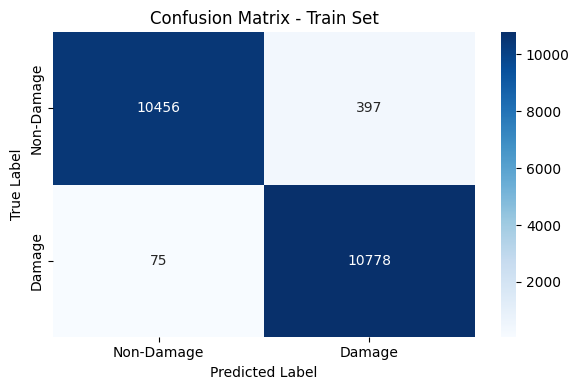

In [3]:
# ====================== Imports ======================
import pandas as pd
import numpy as np
import spacy
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# ====================== Load spaCy model ======================
nlp = spacy.load("en_core_web_sm")

# ====================== Load Data ======================
train_path = "/kaggle/working/train_data.csv"
val_path = "/kaggle/working/val_data.csv"
test_path = "/kaggle/working/test_data.csv"

train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

# ====================== Preprocess Labels ======================
label_map = {'damage': 1, 'non-damage': 0}
for df in [train_df, val_df, test_df]:
    df['Binary_class'] = df['Binary_class'].str.strip().str.lower().map(label_map)
    df['Processed_data'] = df['Processed_data'].fillna("")

# ====================== Lexical Features: TF-IDF ======================
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(train_df['Processed_data'])
X_val_tfidf = vectorizer.transform(val_df['Processed_data'])
X_test_tfidf = vectorizer.transform(test_df['Processed_data'])

# ====================== Morphological Features ======================
def extract_morphological_features(texts):
    pos_tags = []
    lemmas = []
    for doc in nlp.pipe(texts, disable=["parser", "ner"]):
        pos_tags.append([token.pos_ for token in doc])
        lemmas.append([token.lemma_ for token in doc])
    return pos_tags, lemmas

train_pos_tags, train_lemmas = extract_morphological_features(train_df['Processed_data'])
val_pos_tags, val_lemmas = extract_morphological_features(val_df['Processed_data'])
test_pos_tags, test_lemmas = extract_morphological_features(test_df['Processed_data'])

# ====================== Combine Lexical & Morphological Features ======================
def combine_lexical_morphological(X_tfidf, pos_tags, lemmas):
    pos_tag_features = np.array([[len(set(tags))] for tags in pos_tags])
    lemma_features = np.array([[len(set(l))] for l in lemmas])
    X_combined = np.hstack((X_tfidf.toarray(), pos_tag_features, lemma_features))
    return X_combined

X_train_combined = combine_lexical_morphological(X_train_tfidf, train_pos_tags, train_lemmas)
X_val_combined = combine_lexical_morphological(X_val_tfidf, val_pos_tags, val_lemmas)
X_test_combined = combine_lexical_morphological(X_test_tfidf, test_pos_tags, test_lemmas)

# ====================== Class Labels ======================
y_train = train_df['Binary_class'].values
y_val = val_df['Binary_class'].values
y_test = test_df['Binary_class'].values

print("📊 Class Distribution Before SMOTE:\n")
print("Train Set:\n", pd.Series(y_train).value_counts().rename({0: 'Non-Damage', 1: 'Damage'}))
print("\nValidation Set:\n", pd.Series(y_val).value_counts().rename({0: 'Non-Damage', 1: 'Damage'}))
print("\nTest Set:\n", pd.Series(y_test).value_counts().rename({0: 'Non-Damage', 1: 'Damage'}))

# ====================== Apply SMOTE ======================
smote = SMOTE(sampling_strategy=1, k_neighbors=3, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_combined, y_train)

print("\nAfter SMOTE Train Class Distribution:")
print(pd.Series(y_train_smote).value_counts().rename({0: 'Non-Damage', 1: 'Damage'}))

# ====================== CNN Model ======================
input_dim = X_train_smote.shape[1]

cnn_model = Sequential([
    Dense(512, input_dim=input_dim, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = cnn_model.fit(
    X_train_smote, y_train_smote,
    validation_data=(X_val_combined, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop],
    verbose=2
)

# ====================== Evaluation ======================
y_train_proba = cnn_model.predict(X_train_smote).ravel()
y_train_pred = (y_train_proba > 0.5).astype(int)

print("\nTrain Classification Report:")
print(classification_report(y_train_smote, y_train_pred))

accuracy_train = accuracy_score(y_train_smote, y_train_pred)
roc_auc_train = roc_auc_score(y_train_smote, y_train_proba)

print(f'\nTrain Accuracy: {accuracy_train:.4f}')
print(f'Train ROC-AUC: {roc_auc_train:.4f}')

cm_train = confusion_matrix(y_train_smote, y_train_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Non-Damage', 'Damage'],
            yticklabels=['Non-Damage', 'Damage'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Train Set")
plt.tight_layout()
plt.show()
